# Analysis of Mg-Al-Ca

Analysis of the Mg-Al-Ca alloys with data from Hauke
(only vol. fraction at 20K/s as an example)

In [2]:
# python package to interact with openBIS
# see https://pypi.org/project/PyBIS/
from pybis import Openbis
import os
import sys
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import mpltern
import ternary


In [3]:
def get_material_composition(measurement : Openbis) -> tuple:
    parents = measurement.get_parents()

    for p in parents:
        if p.type != 'SAMPLE':
            continue
        properties = p.props.all()
    
    return properties['$name'], properties['elementx'], properties['at_percent'], properties['elementy'], properties['at_percenty'], properties['elementz'], properties['at_percentz'],


In [4]:
##
## create connection to openBIS server
##
oBis = Openbis('https://openbis.imm.rwth-aachen.de/:8443', verify_certificates=True)

In [5]:
##
## read PAT or session token from environment variable
##
pat = os.environ['OPENBISPAT']
#print('OpenBIS personal access token: {}'.format(pat))
# access via personal access token
# Note: for now it needs to be the actual PAT, not the session name
#       i.e. the long string starting with $pat-....

oBis.set_token(pat, save_token=True)

In [6]:
# get experiment with the data

collection = oBis.get_collection('/EXPERIMENTS/MG_ALLOY_ANALYSIS/MG_ALLOY_ANALYSIS_VOLFRACTION')
#print(collection.props)

In [7]:
objects = collection.get_objects()


In [8]:
col_names = ['Name', 'Element X', 'AT% X', 'Element Y', 'AT% Y', 'Element Z', 'AT% Z', 'Measured Value', 'Unit']
df_volume_fraction = pd.DataFrame(columns=col_names)

for obj in objects:
    # first double check that we have the right kind of object, here we look at point measurements (i.e. a single value)
    # skip others
    #print('--------- \n')
    
    if obj.type != 'POINT_MEASUREMENT':
        continue

    permID = obj.attrs.permId

    #get object again (optimise w.r.t. parent/child relationship retrieval in openBIS, ongoing exchange with openBIS developers)
    measurement = oBis.get_object(permID)
    measurement_name = measurement.p.get('$name')

    # extract the measurement
    measurement_value = measurement.p.get('value')
    measurement_unit = measurement.p.get('unit')
    #print('Measurement: {} with permID {} has the value {} {}'.format(measurement_name, permID, measurement_value, measurement_unit))

    # get composition and put into dataframe
    sample_name, elem_x, at_x, elem_y, at_y, elem_z, at_z = get_material_composition(measurement=measurement)
    df_volume_fraction.loc[len(df_volume_fraction),:] = [sample_name, elem_x, at_x, elem_y, at_y, elem_z, at_z, measurement_value, measurement_unit]

    

In [9]:
col_types = {'AT% X' : 'float64', 'AT% Y' : 'float64','AT% Z' : 'float64', 'Measured Value' : 'float64'}
df_volume_fraction = df_volume_fraction.astype(col_types)
df_volume_fraction.head(5)

,Name,Element X,AT% X,Element Y,AT% Y,Element Z,AT% Z,Measured Value,Unit
0,Mg-0Al-1Ca,Mg,99.39,Al,0.00,Ca,0.61,3.39,%
1,Mg-0.2Al-1Ca,Mg,99.21,Al,0.18,Ca,0.61,4.92,%
2,Mg-0.4Al-1Ca,Mg,99.03,Al,0.36,Ca,0.61,4.16,%
3,Mg-0.6Al-1Ca,Mg,98.85,Al,0.54,Ca,0.61,3.88,%
4,Mg-0.8Al-1Ca,Mg,98.67,Al,0.72,Ca,0.61,8.20,%


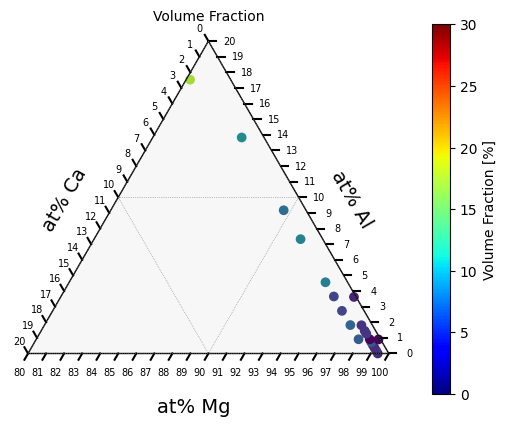

In [11]:
# plot ternary composition analysis

fig, tax = ternary.figure(scale=20)

# custom limits need to sum up to scale, i.e. scale = max-min
tax.set_axis_limits({'b': [80, 100], 'l': [0, 20], 'r': [0, 20]})

tax.get_ticks_from_axis_limits()
tax.set_custom_ticks(fontsize=7, offset=0.02, multiple=5)

#bottom - right - left
# X:Mg, Y:Al, Z:Ca
points_c = tax.convert_coordinates(df_volume_fraction[['AT% X', 'AT% Y', 'AT% Z']].values, axisorder='brl')
tax.scatter(points_c, c=df_volume_fraction['Measured Value'],
            vmin=0.0, vmax=30,
            colorbar=True,colormap='jet',cbarlabel='Volume Fraction [%]')

fontsize = 14
offset = 0.15
tax.left_axis_label  ("at% " + str(df_volume_fraction['Element Z'].unique()[0]), fontsize=fontsize, offset=offset)
tax.right_axis_label ("at% " + str(df_volume_fraction['Element Y'].unique()[0]), fontsize=fontsize, offset=offset)
tax.bottom_axis_label("at% " + str(df_volume_fraction['Element X'].unique()[0]), fontsize=fontsize, offset=offset)
tax.set_title("Volume Fraction", fontsize=10)

tax.boundary(linewidth=1)
tax.gridlines(multiple=10, color="gray")
tax.get_axes().axis('off')

tax.ax.set_aspect('equal', adjustable='box')
tax._redraw_labels()


plt.show()